In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from joblib import dump, load
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

In [2]:
its = pd.read_csv('EMU.ITS.rel_abund.final.csv')
bacteria = pd.read_csv('EMU.16S.rel_abund.final.csv')
amf = pd.read_csv('EMU.18S.rel_abund.final.csv')
env_data = pd.read_csv('env_data.csv')

In [3]:
# Set new index for each DataFrame
def set_custom_index(df, kingdom):
    df['custom_index'] = kingdom + '_' + df['genus'].astype(str) + '_' + df['species'].astype(str)
    df.set_index('custom_index', inplace=True)
    sample_ids = env_data['sample_id'].astype(str).tolist()
    df = df[sample_ids].fillna(0)
    return df.T

its_data = set_custom_index(its, 'Fungi')
bacteria_data = set_custom_index(bacteria, 'Bacteria')
amf_data = set_custom_index(amf, 'AMF')

In [8]:
# Function to perform Random Forest with Grid Search
def random_forest_grid_search(data, labels, n_iter=3):
    avg_accuracy = []
    avg_feature_importance = np.zeros(data.shape[1])
    
    # Hyperparameters to tune
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    
    for i in range(n_iter):
        # Data Splitting
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=i)
        
        # Initialize Random Forest Classifier
        rf = RandomForestClassifier()
        
        # Grid Search
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)
        
        # Best model
        best_model = grid_search.best_estimator_
        
        # Predict and Calculate Accuracy
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        avg_accuracy.append(accuracy)
        
        # Feature Importance
        feature_importance = best_model.feature_importances_
        avg_feature_importance += feature_importance
    
    avg_accuracy = np.mean(avg_accuracy)
    avg_feature_importance /= n_iter
    
    return avg_accuracy, avg_feature_importance, best_model

In [10]:
# Prepare labels
treatment_labels = env_data['Treatment']

# Calculate for each dataset
its_avg_accuracy, its_avg_feature_importance, its_best_model = random_forest_grid_search(its_data, treatment_labels)
bacteria_avg_accuracy, bacteria_avg_feature_importance, bacteria_best_model = random_forest_grid_search(bacteria_data, treatment_labels)
amf_avg_accuracy, amf_avg_feature_importance, amf_best_model = random_forest_grid_search(amf_data, treatment_labels)

# Save the best models
dump(its_best_model, 'its_best_model.joblib')
dump(bacteria_best_model, 'bacteria_best_model.joblib')
dump(amf_best_model, 'amf_best_model.joblib')

['amf_best_model.joblib']

In [11]:
# Load the best models
its_best_model = load('its_best_model.joblib')
bacteria_best_model = load('bacteria_best_model.joblib')
amf_best_model = load('amf_best_model.joblib')

In [14]:
def get_model_metrics(model, data, labels):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    feature_importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': data.columns, 'Importance': feature_importance})
    return accuracy, feature_importance_df

In [15]:
# Get accuracy and feature importances for each dataset
its_accuracy, its_feature_importance_df = get_model_metrics(its_best_model, its_data, treatment_labels)
bacteria_accuracy, bacteria_feature_importance_df = get_model_metrics(bacteria_best_model, bacteria_data, treatment_labels)
amf_accuracy, amf_feature_importance_df = get_model_metrics(amf_best_model, amf_data, treatment_labels)

In [16]:
print('ITS accuracy: ', str(its_avg_accuracy))
print('Bacteria accuracy: ', str(bacteria_avg_accuracy))
print('AMF accuracy: ', str(amf_avg_accuracy))

ITS accuracy:  0.38888888888888884
Bacteria accuracy:  0.5555555555555556
AMF accuracy:  0.6666666666666666


In [20]:
amf_feature_importance_df.sort_values('Importance', ascending = False).head(n = 5)

,Feature,Importance
36,AMF_Paraglomus_Paraglomus bolivianum,0.147186
33,AMF_Rhizophagus _Rhizophagus sp. 1,0.126327
34,AMF_Rhizophagus _Rhizophagus sp. 2,0.086924
10,AMF_Diversispora_Diversispora sp. 2,0.082387
25,AMF_UNK_Glomeraceae sp. 1,0.058390


/home/bostevens/anaconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bostevens/anaconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bostevens/anaconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bostevens/anaconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

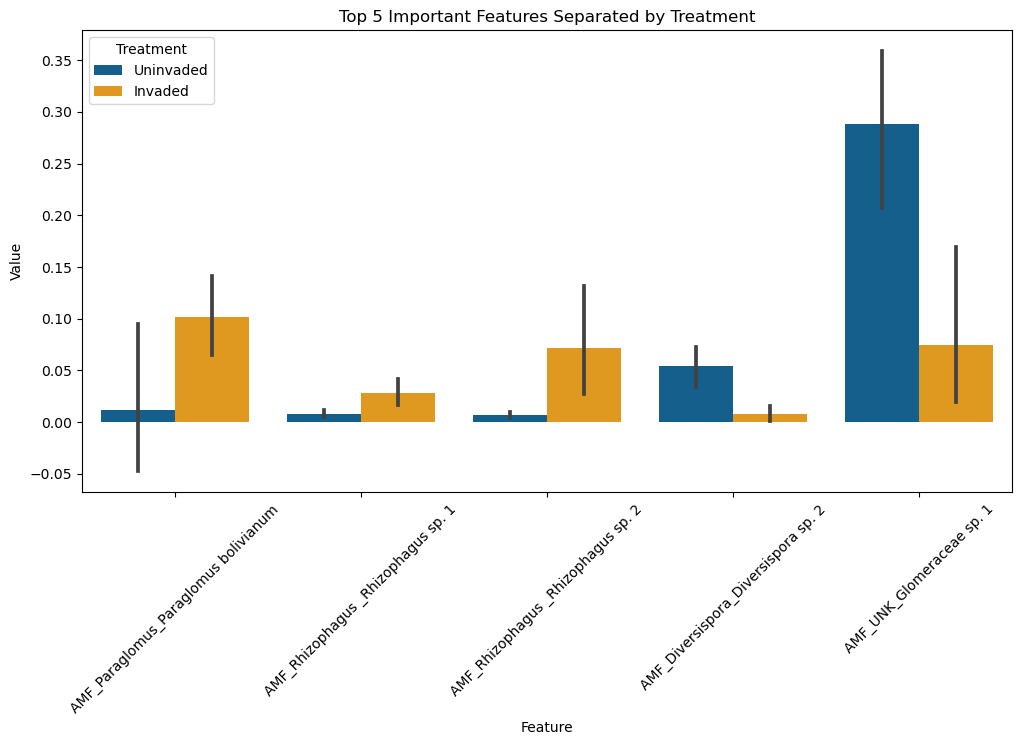

In [18]:
# Reset the index of amf_data if it's an index
amf_data_reset = amf_data.reset_index()

# Filter the top 5 features
# Assume amf_feature_importance_df has been sorted in descending order by feature importance
top_5_features = amf_feature_importance_df.nlargest(5, 'Importance')['Feature'].tolist()

top_5_amf_data = amf_data_reset[top_5_features].copy()  # Create an explicit copy

# Add the 'Sample_ID' column to this filtered dataframe
top_5_amf_data['Sample_ID'] = amf_data_reset['index'].astype(str)  # Ensuring data type consistency

# Convert 'sample_id' in env_data to string type to match 'Sample_ID'
env_data['sample_id'] = env_data['sample_id'].astype(str)

# Merge based on the common identifier 'sample_id' in env_data and 'Sample_ID' in top_5_amf_data
merged_data = pd.merge(env_data, top_5_amf_data, left_on='sample_id', right_on='Sample_ID')

# Update 'Treatment' values in 'merged_data'
merged_data['Treatment'] = merged_data['Treatment'].replace({'BROTEC': 'Invaded', 'BOTGRA': 'Uninvaded'})

# Melt the dataframe to prepare it for seaborn
melted_data = pd.melt(merged_data, id_vars=['Treatment'], value_vars=top_5_features, var_name='Feature', value_name='Value')

# Create the bar plot
plt.figure(figsize=(12, 6))
palette = {'Invaded': '#ffa000', 'Uninvaded': '#0064a0'}  # Define a custom palette
sns.barplot(data=melted_data, x='Feature', y='Value', hue='Treatment', palette=palette)
plt.xlabel('Feature')
plt.ylabel('Value')
plt.title('Top 5 Important Features Separated by Treatment')
plt.xticks(rotation=45)
plt.legend(title='Treatment')  # Adding this line to specify the legend title
plt.savefig('abundance_differences_treatment_amf.jpg', bbox_inches = 'tight', dpi = 300)